In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import emoji
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer , WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report ,accuracy_score,confusion_matrix

In [2]:
name_columns=['polarity','title_review','text_review']
df=pd.read_csv('/kaggle/input/amazon-reviews/test.csv',header=None,names=name_columns)
df.head()

,polarity,title_review,text_review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [3]:
df.shape

(400000, 3)

In [4]:
df.isnull().sum()

polarity         0
title_review    24
text_review      0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.duplicated().sum()

0

In [7]:
df.shape

(399976, 3)

In [8]:
df["full_review"] = df["title_review"] + " " + df["text_review"]
df.head()

,polarity,title_review,text_review,full_review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou..."
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...


In [9]:
df['polarity']=df['polarity'].replace({2:1,1:0})
df.head()

,polarity,title_review,text_review,full_review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou..."
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...


In [10]:
def lowercasing(text):
    return text.lower()

def remove_noise(text):
    # Remove punctuation, numbers, and symbols 
    return re.sub(r'[^a-zA-Z\s]', '', text)

def tokenization(text):
    return word_tokenize(text)
    
def get_max_len(texts):
  return max([len(text) for text in texts])   

def remove_stopwords(tokens):
    stop_words=set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def stemming(tokens):
    stemmer=PorterStemmer()
    [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

In [11]:
df['cleaned_review'] = df['full_review'].apply(lowercasing)

In [12]:
df['cleaned_review'] = df['cleaned_review'].apply(remove_noise)

In [13]:
# Remove emojis
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: emoji.demojize(x))

In [14]:
df['cleaned_review'] = df['cleaned_review'].apply(tokenization)

In [15]:
sent_length = get_max_len(df['cleaned_review'])

In [16]:
df['cleaned_review'] = df['cleaned_review'].apply(remove_stopwords)

In [17]:
df['cleaned_review'] = df['cleaned_review'].apply(stemming)

In [18]:
df.head()

,polarity,title_review,text_review,full_review,cleaned_review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...,great cd lovely pat one great voices generatio...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...,one best game music soundtracks game didnt rea...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...,batteries died within year bought charger jul ...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou...",works fine maha energy better check maha energ...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...,great nonaudiophile reviewed quite bit combo p...


In [19]:
voc_size = 100000
token = Tokenizer(num_words=voc_size , oov_token='UNK')
token.fit_on_texts(df['cleaned_review'])

In [20]:
# Convert texts to sequences
df['cleaned_review'] = token.texts_to_sequences(df['cleaned_review'])

In [21]:
# Pad sequences to the same length
df['cleaned_review'] = pad_sequences(df['cleaned_review'], maxlen=sent_length, padding='post', truncating='post')

In [22]:
x = df['cleaned_review']
y = df['polarity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
# RNN Model

embedding_dim = 1000

model = Sequential()
model.add(Embedding(voc_size+1, embedding_dim, mask_zero=True, input_length=sent_length))

model.add(SimpleRNN(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(SimpleRNN(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(SimpleRNN(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))


model.add(SimpleRNN(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(SimpleRNN(100, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Callbacks
e_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='max',restore_best_weights=True)
callbacklist = [e_stopping]

batch_size = 256
epochs = 100

In [25]:
# Training
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacklist)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 100001000 elements. This may consume a large amount of memory.
  warnings.warn(
I0000 00:00:1733616962.677646      65 service.cc:145] XLA service 0x7e2cfc009a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733616962.677714      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  10/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5020 - loss: 0.9765

I0000 00:00:1733616991.372771      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 43ms/step - accuracy: 0.5826 - loss: 0.7385 - val_accuracy: 0.7208 - val_loss: 0.6203
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7409 - loss: 0.5417 - val_accuracy: 0.7310 - val_loss: 0.5390
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7615 - loss: 0.5050 - val_accuracy: 0.7392 - val_loss: 0.5264
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7687 - loss: 0.4859 - val_accuracy: 0.7404 - val_loss: 0.5245
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7742 - loss: 0.4750 - val_accuracy: 0.7413 - val_loss: 0.5272
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7751 - loss: 0.4691 - val_accuracy: 0.7409 - val_loss: 0.5265
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7756 - loss: 0.4680 - val_accuracy: 0.7384 - val_loss: 0.5245
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7784 - los

In [26]:
sns.set()
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochss=range(1,len(loss)+1)

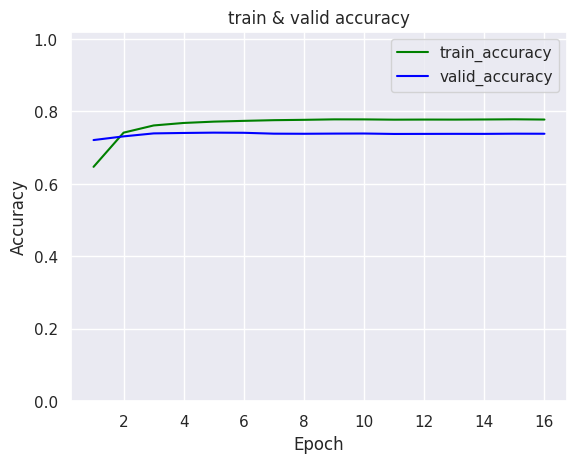

In [27]:
plt.plot(epochss,acc,color='green',label='train_accuracy')
plt.plot(epochss,val_acc,color='blue',label='valid_accuracy')
plt.title('train & valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0,1.02)
plt.show()

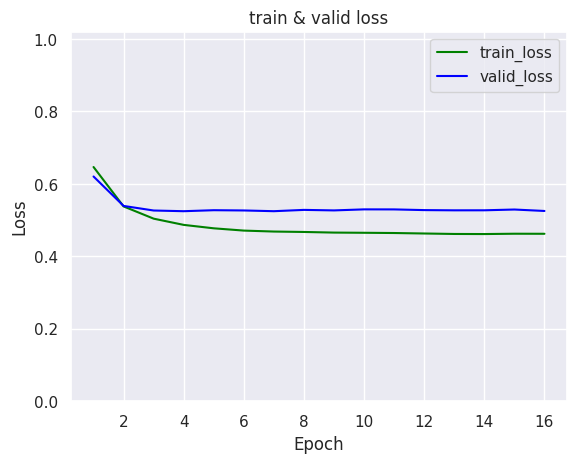

In [28]:
plt.figure()
plt.plot(epochss,loss,color='green',label='train_loss')
plt.plot(epochss,val_loss,color='blue',label='valid_loss')
plt.title('train & valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [29]:
model.evaluate(x_train,y_train)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7487 - loss: 0.5805


[0.5879102945327759, 0.7431026697158813]

In [30]:
model.evaluate(x_test,y_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7217 - loss: 0.6191


[0.6189289689064026, 0.7216985821723938]

In [31]:
y_pred = model.predict(x_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [32]:
y_pred = (y_pred > 0.5).astype(int)

              precision    recall  f1-score   support

           0       0.68      0.83      0.75     40010
           1       0.78      0.62      0.69     39986

    accuracy                           0.72     79996
   macro avg       0.73      0.72      0.72     79996
weighted avg       0.73      0.72      0.72     79996



<Axes: >

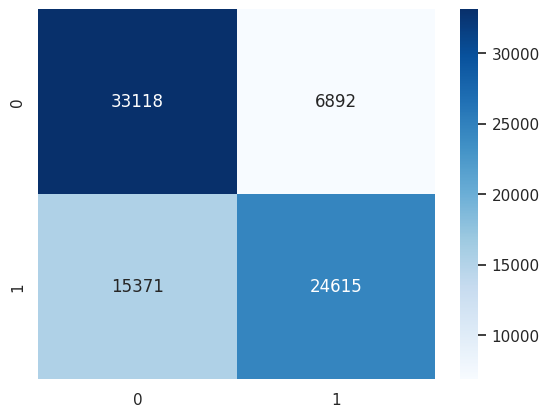

In [33]:
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues')

In [34]:
# LSTM Model

embedding_dim = 1000

model = Sequential()
model.add(Embedding(voc_size+1, embedding_dim, mask_zero=True, input_length=sent_length))

model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(LSTM(100, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Training
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacklist)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 100001000 elements. This may consume a large amount of memory.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 50ms/step - accuracy: 0.6127 - loss: 0.6259 - val_accuracy: 0.7415 - val_loss: 0.4946
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.7700 - loss: 0.4806 - val_accuracy: 0.7436 - val_loss: 0.4993
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.7773 - loss: 0.4583 - val_accuracy: 0.7455 - val_loss: 0.5052
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.7796 - loss: 0.4500 - val_accuracy: 0.7435 - val_loss: 0.5163
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.7790 - loss: 0.4459 - val_accuracy: 0.7441 - val_loss: 0.5288
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.7799 - loss: 0.4424 - val_accuracy: 0.7450 - val_loss: 0.5433
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.7809 - loss: 0.4403 - val_accuracy: 0.7440 - val_loss: 0.5424
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.7822 - los

In [36]:
sns.set()
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochss=range(1,len(loss)+1)

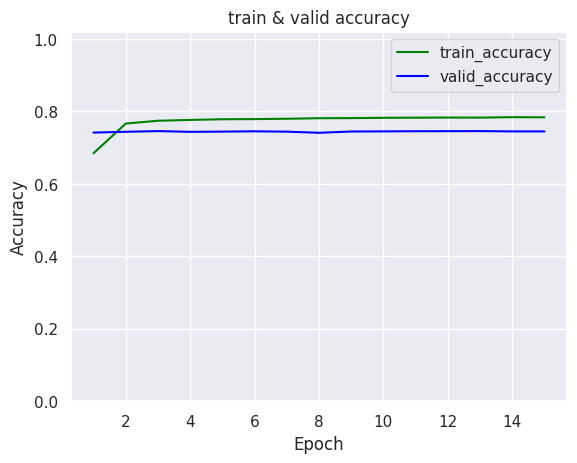

In [37]:
plt.plot(epochss,acc,color='green',label='train_accuracy')
plt.plot(epochss,val_acc,color='blue',label='valid_accuracy')
plt.title('train & valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0,1.02)
plt.show()

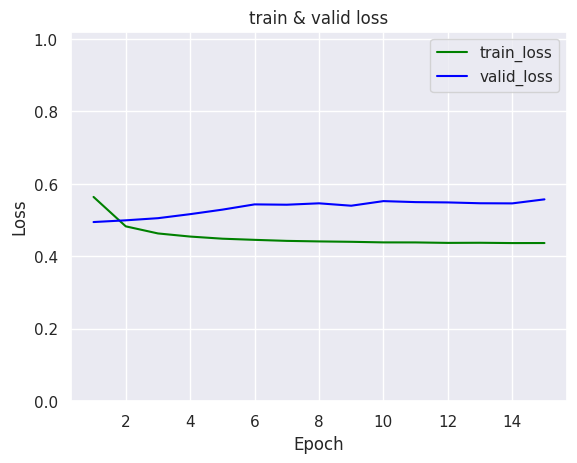

In [38]:
plt.figure()
plt.plot(epochss,loss,color='green',label='train_loss')
plt.plot(epochss,val_loss,color='blue',label='valid_loss')
plt.title('train & valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [39]:
model.evaluate(x_train,y_train)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.7799 - loss: 0.4601


[0.4674050807952881, 0.7722764015197754]

In [40]:
model.evaluate(x_test,y_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7402 - loss: 0.4981


[0.4975833296775818, 0.7415370941162109]

In [41]:
y_pred = model.predict(x_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


In [42]:
y_pred = (y_pred > 0.5).astype(int)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     40010
           1       0.72      0.78      0.75     39986

    accuracy                           0.74     79996
   macro avg       0.74      0.74      0.74     79996
weighted avg       0.74      0.74      0.74     79996



<Axes: >

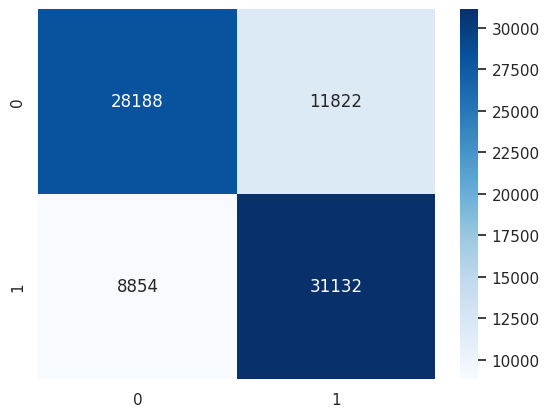

In [43]:
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues')

In [44]:
# GRU Model

embedding_dim = 1000

model = Sequential()
model.add(Embedding(voc_size+1, embedding_dim, mask_zero=True, input_length=sent_length))

model.add(GRU(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(GRU(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(GRU(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(GRU(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(GRU(100, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Training
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacklist)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 100001000 elements. This may consume a large amount of memory.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 51ms/step - accuracy: 0.6045 - loss: 0.7167 - val_accuracy: 0.7388 - val_loss: 0.5030
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.7641 - loss: 0.4895 - val_accuracy: 0.7415 - val_loss: 0.5039
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.7740 - loss: 0.4666 - val_accuracy: 0.7432 - val_loss: 0.5128
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.7733 - loss: 0.4593 - val_accuracy: 0.7449 - val_loss: 0.5216
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.7779 - loss: 0.4509 - val_accuracy: 0.7433 - val_loss: 0.5353
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.7797 - loss: 0.4484 - val_accuracy: 0.7446 - val_loss: 0.5292
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.7797 - loss: 0.4459 - val_accuracy: 0.7452 - val_loss: 0.5351
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.7802 - los

In [46]:
sns.set()
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochss=range(1,len(loss)+1)

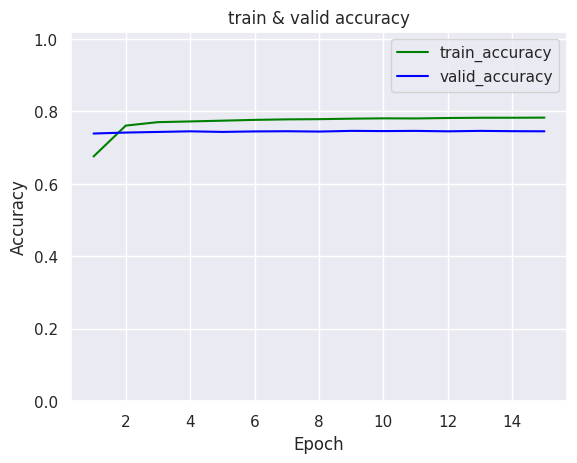

In [47]:
plt.plot(epochss,acc,color='green',label='train_accuracy')
plt.plot(epochss,val_acc,color='blue',label='valid_accuracy')
plt.title('train & valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0,1.02)
plt.show()

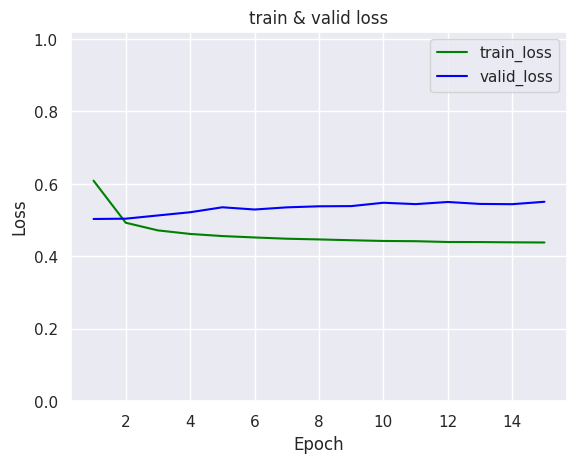

In [48]:
plt.figure()
plt.plot(epochss,loss,color='green',label='train_loss')
plt.plot(epochss,val_loss,color='blue',label='valid_loss')
plt.title('train & valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [49]:
model.evaluate(x_train,y_train)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accuracy: 0.7734 - loss: 0.4653


[0.4731336832046509, 0.7667573094367981]

In [50]:
model.evaluate(x_test,y_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7367 - loss: 0.5080


[0.5072230696678162, 0.7373868823051453]

In [51]:
y_pred = model.predict(x_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


In [52]:
y_pred = (y_pred > 0.5).astype(int)

              precision    recall  f1-score   support

           0       0.77      0.68      0.72     40010
           1       0.71      0.80      0.75     39986

    accuracy                           0.74     79996
   macro avg       0.74      0.74      0.74     79996
weighted avg       0.74      0.74      0.74     79996



<Axes: >

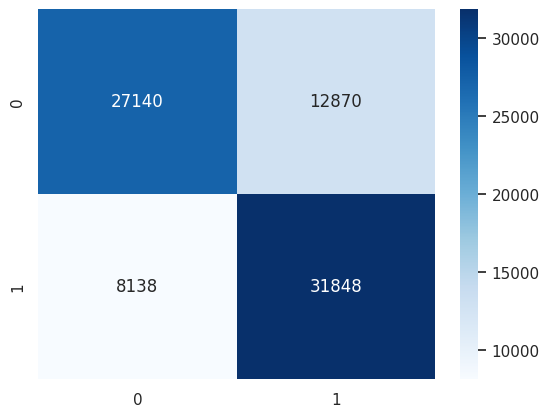

In [53]:
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues')